In [69]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import  classification_report

# Preprocess Data #

In [ ]:
#Load in data
label_list = ['COVID','Lung_Opacity','Normal','Viral_Pneumonia']
img_dir = []
labels = []

def get_path_list(label):
    print(label)
    dir_path = 'COVID-19_Radiography_Dataset/{}'.format(label)
    data = []
    labels = []
    for file in os.listdir(dir_path):
        data.append(os.path.join(dir_path,file))
        labels.append(label)
    return data,labels

def get_all_paths(label_list):
    for label in label_list:
        temp_data, temp_labels = get_path_list(label)
        img_dir.extend(temp_data)
        labels.extend(temp_labels)
get_all_paths(label_list)

In [3]:
len(img_dir),len(labels)

(21165, 21165)

In [4]:
#Convert to dataframe
unsplit_data = {'Image':img_dir,'Label':labels}
unsplit_data = pd.DataFrame(unsplit_data)

In [5]:
unsplit_data.head()

,Image,Label
0,COVID-19_Radiography_Dataset/COVID\COVID-1.png,COVID
1,COVID-19_Radiography_Dataset/COVID\COVID-10.png,COVID
2,COVID-19_Radiography_Dataset/COVID\COVID-100.png,COVID
3,COVID-19_Radiography_Dataset/COVID\COVID-1000.png,COVID
4,COVID-19_Radiography_Dataset/COVID\COVID-1001.png,COVID


In [6]:
unsplit_data['Label'].value_counts()
#Unbalanced data set. precision/recall maybe more important than accuracy

Normal             10192
Lung_Opacity        6012
COVID               3616
Viral_Pneumonia     1345
Name: Label, dtype: int64

In [7]:
#Split data into 80,10,10
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(unsplit_data['Image'],unsplit_data['Label'],test_size=.2,random_state=42)
#x_val,x_test,y_test,y_val = train_test_split(x_val,y_val,test_size=.5,random_state=42)

In [106]:
#Make datagens/debug issue with train test val split
train_gen = pd.DataFrame({'Image':x_train,'Label':y_train})
val_gen = pd.DataFrame({'Image':x_val,'Label':y_val})
x_val,x_test,y_val,y_test = train_test_split(val_gen['Image'],val_gen['Label'],test_size=.5,random_state=42)
test_gen = pd.DataFrame({'Image':x_test,'Label':y_test})
val_gen = pd.DataFrame({'Image':x_val,'Label':y_val})

In [9]:
#Ensure each split has enough of each data type
train_gen['Label'].value_counts()

Normal             8168
Lung_Opacity       4766
COVID              2915
Viral_Pneumonia    1083
Name: Label, dtype: int64

In [10]:
val_gen['Label'].value_counts()

Normal             1008
Lung_Opacity        622
COVID               360
Viral_Pneumonia     126
Name: Label, dtype: int64

In [11]:
#test_gen['Label'].value_counts()

## Make Data generators For resnet##

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [90]:
train_data_gen = ImageDataGenerator(
                               preprocessing_function=preprocess_input,
                               rotation_range=15,
                               width_shift_range=.2,
                               height_shift_range=.2,
                               horizontal_flip=True)
val_data_gen =  ImageDataGenerator(preprocessing_function=preprocess_input)

In [107]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    test_gen,
    x_col='Image',
    y_col = 'Label',
    target_size = (224,244),
    batch_size = 64,
    shuffle = False,
    class_mode='sparse',
    validate_filenames=True
)

Found 1058 validated image filenames belonging to 4 classes.


In [92]:
train_generator = train_data_gen.flow_from_dataframe(
    train_gen,
    x_col='Image',
    y_col = 'Label',
    target_size = (224,244),
    batch_size = 64,
    shuffle = True,
    class_mode='sparse',
    validate_filenames=True
)

val_generator = val_data_gen.flow_from_dataframe(
    val_gen,
    x_col='Image',
    y_col = 'Label',
    target_size = (224,244),
    batch_size = 64,
    shuffle = True,
    class_mode='sparse',
    validate_filenames=True
)

Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.


# Resnet as a feature extractor #

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2,l1

In [89]:
#Does not save properly
filepath = 'checkpoints/my_best_model2.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 monitor='val_loss',
                                                save_best_only=True,
                                                 verbose=1,
                                                mode='min')
callbacks = [checkpoint]

In [172]:
#Attempt without finetuning
resnet = ResNet50(include_top=False,weights='imagenet', pooling='avg')
#resnet.summary()

In [190]:
REG_STRENGTH = 0.05
resnet.trainable = False
model = Sequential()
model.add(resnet)
#model.add(GlobalAveragePooling2D())
#model.add(Flatten())
model.add(Dense(256,activation='relu',kernel_regularizer=l2(REG_STRENGTH)))
model.add(Dropout(.1))
model.add(Dense(4,activation='softmax'))

In [175]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_12 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 1028      
Total params: 24,113,284
Trainable params: 525,572
Non-trainable params: 23,587,712
_________________________________________________________________


In [192]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [143]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [193]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=callbacks)

Epoch 1/5
67/67 [==============================] - ETA: 0s - loss: 20.7070 - accuracy: 0.6750  

In [100]:
#https://www.kaggle.com/shub20/lung-image-classification-97-acc
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(20)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

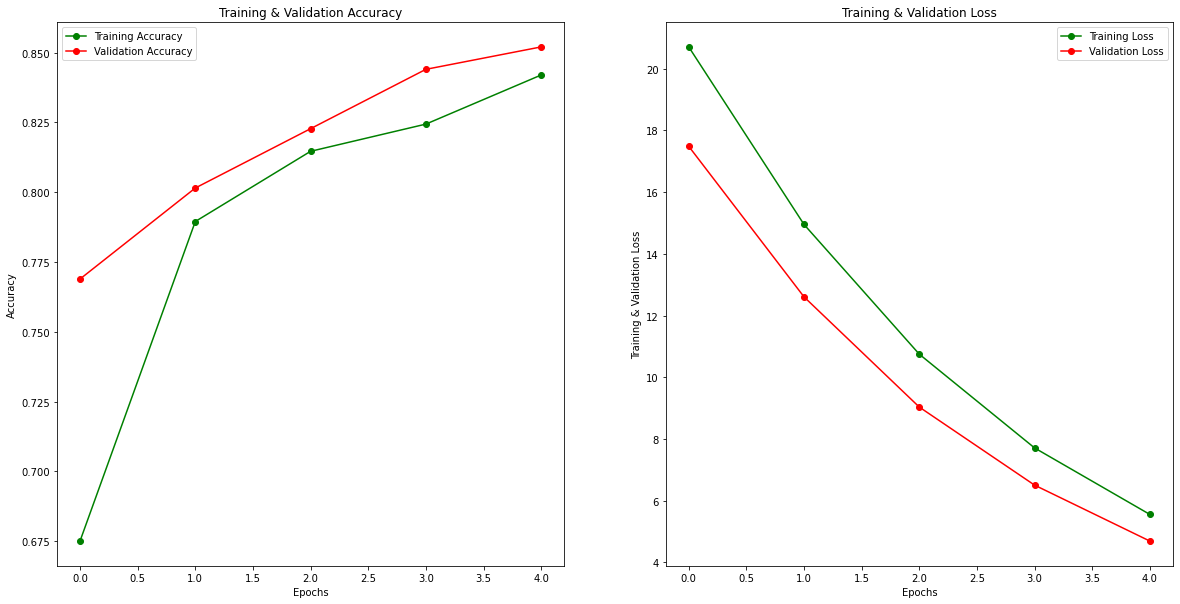

In [194]:
plot_accuracy_loss_chart(history)
#Right hyperparamaters found, train for more epochs later

# Finetuned Resnet #

In [ ]:
#Fine tuned resnet50
filepath = 'checkpoints/fine_tune.hdf5'
checkpoint2 = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 monitor='val_loss',
                                                save_best_only=True,
                                                 verbose=1,
                                                mode='min')
callbacks2 = [checkpoint2]

In [94]:
resnet2 = ResNet50(include_top=False,weights='imagenet', pooling='avg')
#resnet2.summary()

In [95]:
len(resnet2.layers)
fine_tune_at = 150

for layer in resnet2.layers[:fine_tune_at]:
  layer.trainable =  False

In [96]:
#REG_STRENGTH = 0.05
model2 = Sequential()
model2.add(resnet2)
model2.add(Dense(4,activation='softmax'))

In [97]:
model2.compile(optimizer=Adam(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [98]:
history = model2.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks2)

Epoch 1/20
265/265 [==============================] - ETA: 0s - loss: 0.6532 - accuracy: 0.7462  

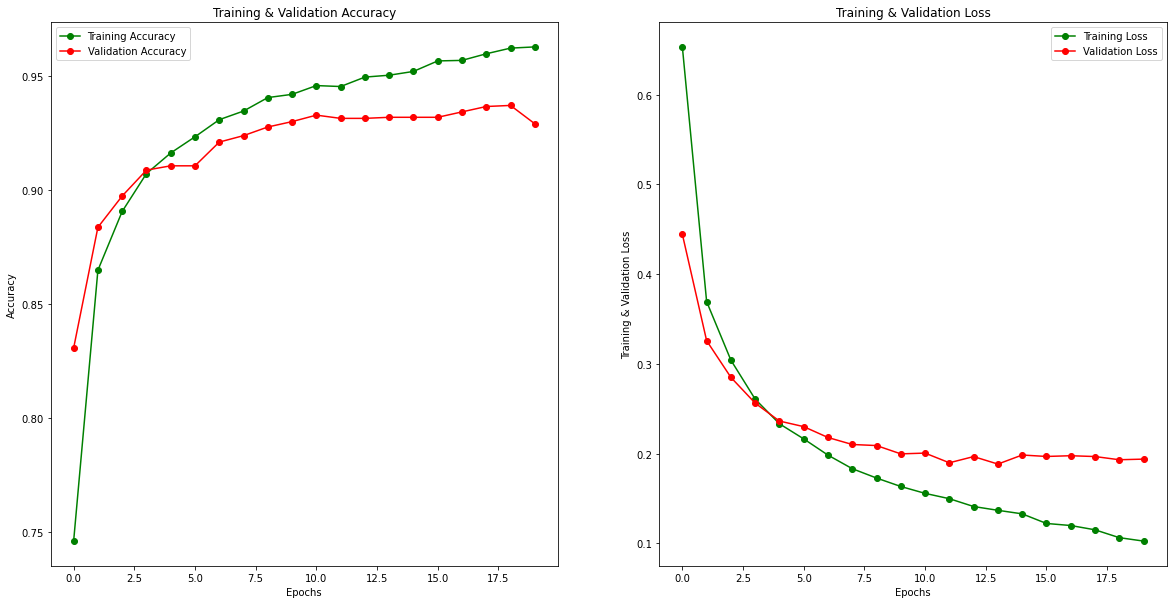

In [101]:
plot_accuracy_loss_chart(history)

## Evaluate the Performance #

In [102]:
model2.evaluate(test_gen)
#0.9239490032196045 accuracy

34/34 [==============================] - 10s 291ms/step - loss: 0.2190 - accuracy: 0.9239

[0.2190236896276474, 0.9239490032196045]

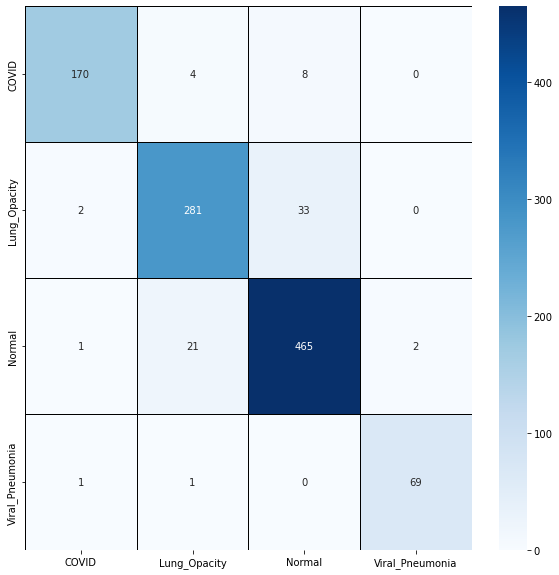

In [108]:
pred = model2.predict(test_generator)
pred = np.argmax(pred,axis=1)
pred[:15]
cm = confusion_matrix(test_generator.classes, pred)
#https://www.kaggle.com/shub20/lung-image-classification-97-acc
class_names = ['COVID','Lung_Opacity','Normal','Viral_Pneumonia']
cm = pd.DataFrame(cm, index = ['0', '1', '2','3'], columns = ['0', '1', '2','3'])
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm,
        cmap = 'Blues',
        linecolor = 'black',
        linewidth = 1,
        annot = True,
        fmt = '',
        xticklabels = class_names,
        yticklabels = class_names)

plot_confusion_matrix(cm)

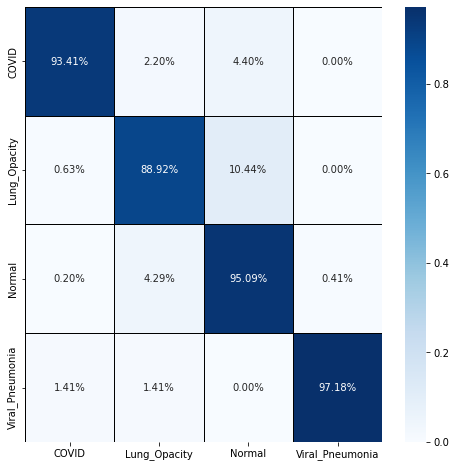

In [109]:
cm = confusion_matrix(test_generator.classes, pred, normalize='true')
def plot_confusion_matrix2 (cm):
    plt.figure(figsize = (8,8))
    sns.heatmap(
        cm,
        cmap = 'Blues',
        linecolor = 'black',
        linewidth = 1,
        annot = True,
        fmt=".2%",
        xticklabels = class_names,
        yticklabels = class_names)

plot_confusion_matrix2(cm)

In [111]:
print(classification_report(test_generator.classes,pred,target_names= class_names))
model2.save_weights('resnet.hdf5')

                 precision    recall  f1-score   support

          COVID       0.98      0.93      0.96       182
   Lung_Opacity       0.92      0.89      0.90       316
         Normal       0.92      0.95      0.93       489
Viral_Pneumonia       0.97      0.97      0.97        71

       accuracy                           0.93      1058
      macro avg       0.95      0.94      0.94      1058
   weighted avg       0.93      0.93      0.93      1058



# MobileNetV2 #

New data generators

In [17]:
train_data_gen = ImageDataGenerator(
                               rescale=1./255,
                               rotation_range=15,
                               width_shift_range=.2,
                               height_shift_range=.2,
                               horizontal_flip=True)
val_data_gen =  ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_dataframe(
    train_gen,
    x_col='Image',
    y_col = 'Label',
    target_size = (224,244),
    batch_size = 64,
    shuffle = True,
    class_mode='sparse',
    validate_filenames=True
)

val_generator = val_data_gen.flow_from_dataframe(
    val_gen,
    x_col='Image',
    y_col = 'Label',
    target_size = (224,244),
    batch_size = 64,
    shuffle = True,
    class_mode='sparse',
    validate_filenames=True
)

Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.


In [54]:
from tensorflow.keras.applications import MobileNetV2
mobilenet = MobileNetV2(include_top=False, weights='imagenet',pooling='avg')

In [55]:
len(mobilenet.layers)
fine_tune_at = 125
for layer in mobilenet.layers[:fine_tune_at]:
  layer.trainable =  False

In [56]:
checkpoint_path = 'checkpoints/mobilenet2'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss',
                                                save_best_only=True,
                                                 verbose=1,
                                                mode='min')
callbacks2 = [checkpoint2]


In [57]:
model3 = Sequential()
model3.add(mobilenet)
model3.add(Dropout(.25))
model3.add(Dense(4,activation='softmax'))

In [49]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 1,531,524
Non-trainable params: 731,584
_________________________________________________________________


In [58]:
model3.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
history = model3.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks2)

Epoch 1/10
265/265 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.8252  

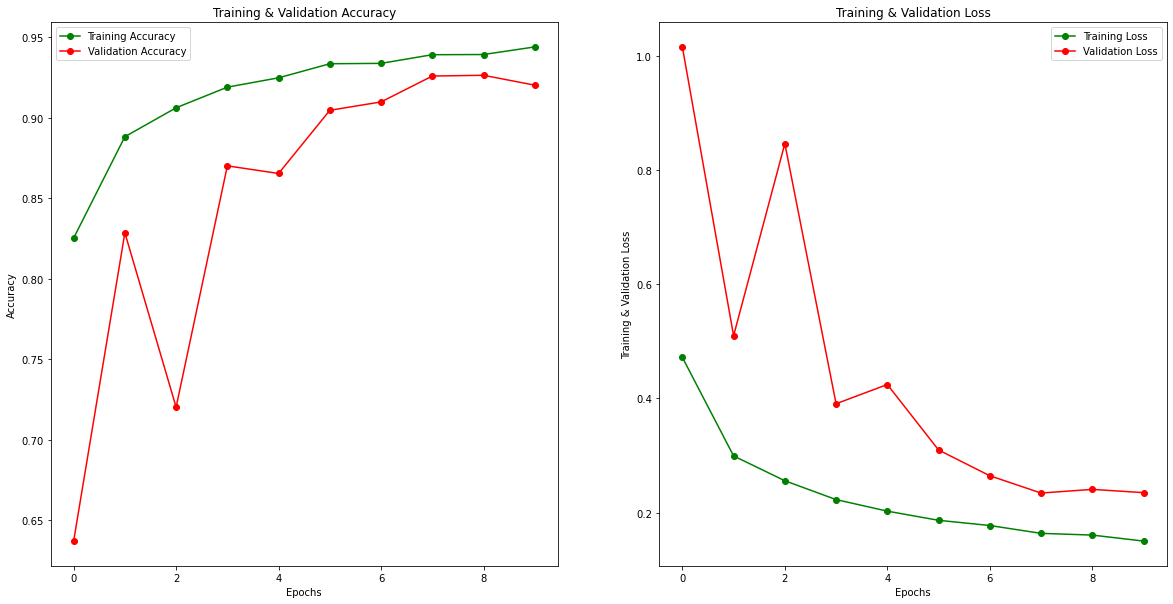

In [60]:
plot_accuracy_loss_chart(history)

Performance Metrics

In [84]:
test_data_gen =  ImageDataGenerator(rescale=1./255)

test_generator = val_data_gen.flow_from_dataframe(
    test_gen,
    x_col='Image',
    y_col = 'Label',
    target_size = (224,244),
    batch_size = 64,
    shuffle=False,
    class_mode='sparse',
    validate_filenames=True
)

Found 2117 validated image filenames belonging to 4 classes.


In [62]:
model3.evaluate(test_generator)
#.9135

34/34 [==============================] - 3s 103ms/step - loss: 0.2465 - accuracy: 0.9136

[0.24654746055603027, 0.9135569334030151]

In [63]:
model3.save_weights('mobilenet.hdf5')

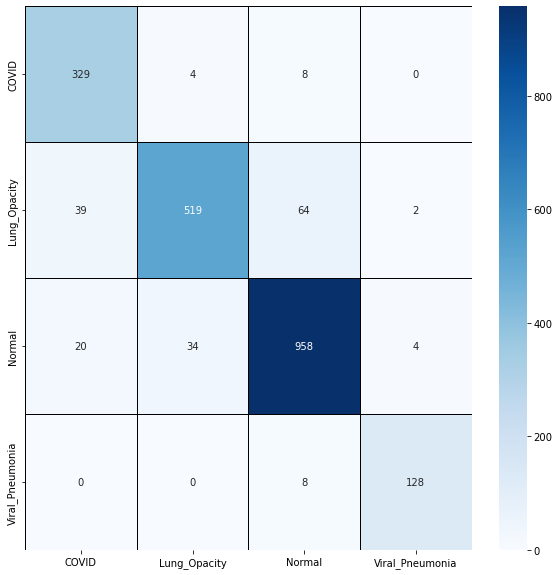

In [85]:
pred = model3.predict(test_generator)
pred = np.argmax(pred,axis=1)
pred[:15]
cm = confusion_matrix(test_generator.classes, pred)
#https://www.kaggle.com/shub20/lung-image-classification-97-acc
class_names = ['COVID','Lung_Opacity','Normal','Viral_Pneumonia']
cm = pd.DataFrame(cm, index = ['0', '1', '2','3'], columns = ['0', '1', '2','3'])
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm,
        cmap = 'Blues',
        linecolor = 'black',
        linewidth = 1,
        annot = True,
        fmt = '',
        xticklabels = class_names,
        yticklabels = class_names)

plot_confusion_matrix(cm)

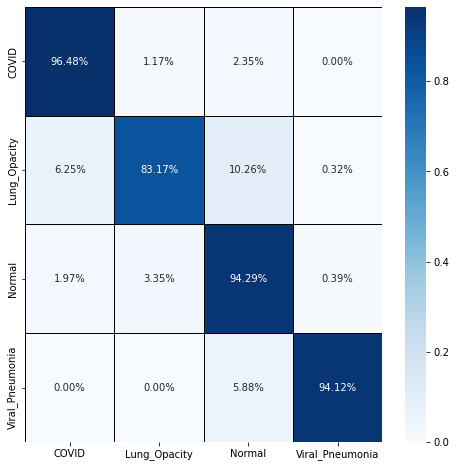

In [86]:
cm = confusion_matrix(test_generator.classes, pred, normalize='true')
def plot_confusion_matrix2 (cm):
    plt.figure(figsize = (8,8))
    sns.heatmap(
        cm,
        cmap = 'Blues',
        linecolor = 'black',
        linewidth = 1,
        annot = True,
        fmt=".2%",
        xticklabels = class_names,
        yticklabels = class_names)

plot_confusion_matrix2(cm)

In [87]:
print(classification_report(test_generator.classes,pred,target_names= class_names))

                 precision    recall  f1-score   support

          COVID       0.85      0.96      0.90       341
   Lung_Opacity       0.93      0.83      0.88       624
         Normal       0.92      0.94      0.93      1016
Viral_Pneumonia       0.96      0.94      0.95       136

       accuracy                           0.91      2117
      macro avg       0.91      0.92      0.92      2117
   weighted avg       0.92      0.91      0.91      2117

